In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import Dataset, GraphsizePretrained
from tqdm import tqdm
from tqdm.notebook import tqdm
from time import time
import numpy as np

Using backend: pytorch


In [2]:
%%time
graph_builder = GraphsizePretrained(w=2, verbose=True,
                   pretrained_vec='/home/mangaravite/Documentos/pretrained_vectors/glove.6B.300d.txt')

400000it [00:22, 17743.90it/s]


CPU times: user 22.3 s, sys: 511 ms, total: 22.8 s
Wall time: 22.7 s


In [3]:
dataset = Dataset('/home/mangaravite/Documentos/datasets/classification/datasets/webkb/')
fold = next(dataset.get_fold_instances(10, with_val=False))
fold._fields, len(fold.X_train)

(('X_train', 'y_train', 'X_test', 'y_test'), 7376)

In [4]:
import torch
import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
from dgl.nn.pytorch.conv import GraphConv, GATConv
from dgl.nn.pytorch.glob import GlobalAttentionPooling

from sklearn.preprocessing import LabelEncoder

from itertools import repeat

import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
%%time
graph_builder.fit(fold.X_train, fold.y_train)

100%|██████████| 7376/7376 [00:06<00:00, 1206.85it/s]


CPU times: user 7.34 s, sys: 52.2 ms, total: 7.4 s
Wall time: 7.38 s


GraphsizePretrained(pretrained_vec='/home/mangaravite/Documentos/pretrained_vectors/glove.6B.300d.txt',
                    verbose=None)

In [6]:
len(graph_builder.g.edges), len(graph_builder.g)

(91187, 20770)

In [7]:
list(map(lambda x: (x,graph_builder.g.degree()[x]), graph_builder.label_ids))

[(0, 12418),
 (1, 19960),
 (2, 9382),
 (3, 3918),
 (4, 9014),
 (5, 12838),
 (6, 2901)]

In [67]:
class GenericGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim,
                 drop=.5, n_heads=8, attn_drop=.5,
                 activation=F.leaky_relu, n_convs=2,
                 first_hidden='emb', encoders={'term','label'},
                 device='cpu:0'):
        super(GenericGAT, self).__init__()
        self.device = torch.device(device)
        self.first_hidden = first_hidden
        
        self.encoders = nn.ModuleDict({
            k: nn.Linear(in_dim, hidden_dim).to(self.device) for k in encoders
        })
        
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim, residual=True, num_heads=n_heads, activation=activation,
                    feat_drop=drop, attn_drop=attn_drop).to(self.device) for _ in range(n_convs)
        ])
        self.down_proj = [
            nn.Linear(n_heads*hidden_dim, hidden_dim).to(self.device) for _ in range(n_convs)
        ]
        
    def forward(self, G, **kwargs):
        with G.local_scope():
            h = G.ndata[self.first_hidden].float()
            for (k, mask) in kwargs.items():
                if k in self.encoders:
                    if mask is not None:
                        h[ mask ] = self.encoders[k]( h[ mask ] )
                    else:
                        h = self.encoders[k]( h )

            for l, conv in enumerate(self.layers):
                h = conv(G, h)
                h = h.view(h.shape[0], -1)
                h = self.down_proj[l]( h )
                #h = F.relu( h )
        return h
        

In [83]:
hidden_l = 300
input_l = 300
n_heads = 3
drop=0.6
attn_drop=0.6
device=torch.device('cuda:0')

In [84]:
big_graph_dgl = dgl.DGLGraph()
big_graph_dgl.from_networkx(graph_builder.g, node_attrs=['emb', 'label', 'idx'] )
big_graph_dgl = big_graph_dgl.to(device)

In [85]:
gat = GenericGAT( input_l, hidden_l, n_heads=n_heads,
                 drop=drop, attn_drop=attn_drop,
                 activation=None, device='cuda:0' ).to(device)
norm = nn.BatchNorm1d(hidden_l).to(device)

In [86]:
loss_func = nn.CosineEmbeddingLoss(reduction='mean').to(device)
optimizer = optim.AdamW( gat.parameters(), lr=5e-3, weight_decay=5e-3)



#RMSprop

In [87]:
gat.train()
best = None
label_idx = big_graph_dgl.ndata['label'].nonzero().flatten()
nepochs = 200
lr = 2.*5e-2
for e in tqdm(range(nepochs), total=nepochs):
    if e % 50 == 1:
        gat = best_model
        optimizer = optim.AdamW( gat.parameters(), lr=lr/2, weight_decay=5e-3)
    h = gat(big_graph_dgl, label=label_idx, term=range(max(label_idx),len(graph_builder.g)))
    h = norm(h)
    labels_hiddens = h[label_idx]
    A = []
    B = []
    y = []
    for i in range(labels_hiddens.size()[0]):
        for j in range(i+1, labels_hiddens.size()[0]):
            A.append( labels_hiddens[i] )
            B.append( -1.*labels_hiddens[j] )
            y.append( 1 )

            #A.append( labels_hiddens[i] )
            #B.append( labels_hiddens[j] )
            #y.append( -1. )

    B=torch.cat(B).reshape( len(y), hidden_l ).to(device)
    A=torch.cat(A).reshape( len(y), hidden_l ).to(device)
    y=torch.Tensor(y).to(device)
    loss = loss_func(A, B, target=y)
    loss.backward()
    optimizer.step()
    if best is None or loss.item() < best:
        best = loss.item()
        best_model = gat
        h_best = h.detach().cpu()
    print(f"epoch: {e}, loss: {loss.item()-1:.6} min_loss: {best-1:.6}")
    del labels_hiddens, loss, A, B, y, h
    if (best-1.) < -0.8:
        break

epoch: 0, loss: 0.562547 min_loss: 0.562547
epoch: 1, loss: 0.745174 min_loss: 0.562547
epoch: 2, loss: 0.749047 min_loss: 0.562547
epoch: 3, loss: 0.413777 min_loss: 0.413777
epoch: 4, loss: 0.0116392 min_loss: 0.0116392
epoch: 5, loss: 0.10469 min_loss: 0.0116392
epoch: 6, loss: 0.679635 min_loss: 0.0116392
epoch: 7, loss: 0.74814 min_loss: 0.0116392
epoch: 8, loss: -0.11252 min_loss: -0.11252
epoch: 9, loss: 0.20016 min_loss: -0.11252
epoch: 10, loss: 0.741583 min_loss: -0.11252
epoch: 11, loss: 0.709696 min_loss: -0.11252
epoch: 12, loss: -0.0664742 min_loss: -0.11252
epoch: 13, loss: 0.655483 min_loss: -0.11252
epoch: 14, loss: 0.358606 min_loss: -0.11252
epoch: 15, loss: 0.683395 min_loss: -0.11252
epoch: 16, loss: 0.50928 min_loss: -0.11252
epoch: 17, loss: 0.712182 min_loss: -0.11252
epoch: 18, loss: -0.0127821 min_loss: -0.11252
epoch: 19, loss: 0.625657 min_loss: -0.11252
epoch: 20, loss: 0.716912 min_loss: -0.11252
epoch: 21, loss: 0.816538 min_loss: -0.11252
epoch: 22, loss

epoch: 180, loss: 0.0631175 min_loss: -0.14701
epoch: 181, loss: 0.153288 min_loss: -0.14701
epoch: 182, loss: 0.0532893 min_loss: -0.14701
epoch: 183, loss: 0.0334548 min_loss: -0.14701
epoch: 184, loss: 0.186988 min_loss: -0.14701
epoch: 185, loss: -0.100146 min_loss: -0.14701
epoch: 186, loss: -0.0197325 min_loss: -0.14701
epoch: 187, loss: -0.0570745 min_loss: -0.14701
epoch: 188, loss: 0.636643 min_loss: -0.14701
epoch: 189, loss: -0.013597 min_loss: -0.14701
epoch: 190, loss: 0.00320041 min_loss: -0.14701
epoch: 191, loss: 0.0223163 min_loss: -0.14701
epoch: 192, loss: 0.0254414 min_loss: -0.14701
epoch: 193, loss: -0.0273661 min_loss: -0.14701
epoch: 194, loss: -0.092611 min_loss: -0.14701
epoch: 195, loss: -0.0957268 min_loss: -0.14701
epoch: 196, loss: 0.0950958 min_loss: -0.14701
epoch: 197, loss: 0.167313 min_loss: -0.14701
epoch: 198, loss: 0.137133 min_loss: -0.14701
epoch: 199, loss: 0.0843574 min_loss: -0.14701



In [88]:
h_best[label_idx] # Embedding dos labels (Distâncias maximizadas)

tensor([[-0.8895, -0.6367, -0.7181,  ..., -0.8215,  0.5532, -0.9118],
        [ 1.2202,  0.5135,  0.9280,  ...,  1.1836, -1.3328,  1.2457],
        [-1.2736, -1.1510, -1.0340,  ..., -1.2820,  1.5127, -1.3394],
        ...,
        [ 1.2201,  0.5129,  0.9276,  ...,  1.1837, -1.3322,  1.2463],
        [-0.8482, -0.9246, -0.7740,  ..., -1.0199,  1.1720, -0.9443],
        [ 0.9211, -0.9799,  1.0628,  ...,  0.9166, -0.5894,  0.7625]])

In [89]:
                        # embedding dos termos novos
h_best[len(label_idx):] # o mapeamento é (o inverso de) node_mapper[big_graph.ndata['idx']]

tensor([[-0.6025,  1.0785, -0.9206,  ..., -0.7186, -0.1810, -0.2811],
        [-0.8710,  1.6063, -1.4402,  ..., -0.8364,  0.4590, -0.5653],
        [-1.2875, -0.6703, -1.0670,  ..., -1.1760,  1.5474, -1.3180],
        ...,
        [ 1.1737,  0.6114,  0.8932,  ...,  1.1657, -1.2912,  1.2110],
        [ 0.9594,  1.5962,  0.6850,  ...,  1.2438, -1.0652,  1.1647],
        [-1.0153, -1.7121, -0.8595,  ..., -1.1186,  0.7670, -1.2161]])

In [90]:
h_best[100:105]

tensor([[-0.8709,  1.6067, -1.4403,  ..., -0.8368,  0.4593, -0.5657],
        [-1.0155, -1.7122, -0.8597,  ..., -1.1184,  0.7670, -1.2160],
        [ 0.9486,  1.5543,  0.7208,  ...,  1.1264, -0.5519,  1.1433],
        [ 0.8043, -1.7643,  1.3015,  ...,  0.8443, -0.2436,  0.4924],
        [ 0.8043, -1.7644,  1.3014,  ...,  0.8441, -0.2440,  0.4924]])

In [91]:
big_graph_dgl.ndata['emb'][100:105]

tensor([[ 0.0579, -0.1107, -0.0042,  ..., -0.6603, -0.2488,  1.3071],
        [-0.2994, -0.1609,  0.1563,  ..., -0.2428, -0.3243, -0.1272],
        [ 0.0094,  0.7481,  0.3866,  ..., -0.0848,  0.6544,  0.3899],
        [-0.0124, -0.3303, -0.3383,  ..., -0.3146, -0.3423,  0.1724],
        [ 0.1775, -0.0171, -0.3588,  ..., -0.6010, -0.0863, -0.2695]],
       device='cuda:0', dtype=torch.float64)

In [18]:
zdfgsrvsdtvhsfhvg

NameError: name 'zdfgsrvsdtvhsfhvg' is not defined

In [92]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

In [93]:
# Variância média DAS hidden dimensions dos labels &
#     -> O quanto as hidden estão variando entre as labels
#        Quanto maior esse valor, mais "diferente" são as representações dos LABELS
# Variância média ENTRE A MÉDIA DAS hidden dimensions dos labels
#     -> O quanto as hiddens estão variando entre si
#        Quanto maior esse valor, mais "diferente" são as representações das DIMENSÕES
#        Ou seja, VAR(AVG(h1), AVG(h2), ..., AVG(hn)) é alto
h_best[label_idx].std(axis=0).mean(), h_best[label_idx].mean(axis=0).std()

(tensor(1.0046), tensor(0.1206))

In [94]:
nbins = 30

Text(0.5, 1.0, 'Labels\n[VAR(h1), VAR(h2), ..., VAR(hn)]')

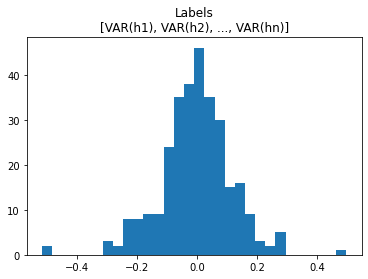

In [95]:
plt.hist( h_best[label_idx].mean(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Labels\n[VAR(h1), VAR(h2), ..., VAR(hn)]' )

In [96]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=10, metric='cosine')
X = tsne.fit_transform(h_best.detach().cpu().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20770 samples in 0.016s...
[t-SNE] Computed neighbors for 20770 samples in 6.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20770
[t-SNE] Computed conditional probabilities for sample 2000 / 20770
[t-SNE] Computed conditional probabilities for sample 3000 / 20770
[t-SNE] Computed conditional probabilities for sample 4000 / 20770
[t-SNE] Computed conditional probabilities for sample 5000 / 20770
[t-SNE] Computed conditional probabilities for sample 6000 / 20770
[t-SNE] Computed conditional probabilities for sample 7000 / 20770
[t-SNE] Computed conditional probabilities for sample 8000 / 20770
[t-SNE] Computed conditional probabilities for sample 9000 / 20770
[t-SNE] Computed conditional probabilities for sample 10000 / 20770
[t-SNE] Computed conditional probabilities for sample 11000 / 20770
[t-SNE] Computed conditional probabilities for sample 12000 / 20770
[t-SNE] Computed conditional probabilities for sam

In [97]:
dataset.dname

'webkb'

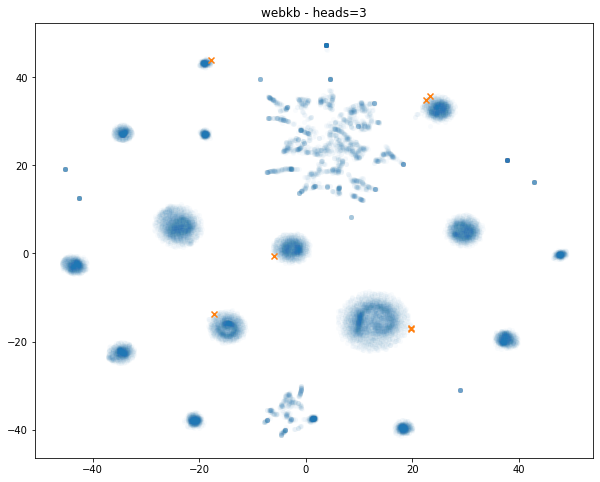

In [98]:
x,y = X.T
plt.figure(figsize=(10,8))
plt.scatter(x[len(label_idx):],y[len(label_idx):], linewidths= 0.0, s=25, alpha=0.025)
plt.scatter(x[label_idx.cpu().numpy()],y[label_idx.cpu().numpy()], marker='x')
plt.xlim( (x.min()-5, x.max()+5) )
plt.ylim( (y.min()-5, y.max()+5) )
plt.title(f'{dataset.dname} - heads={n_heads}')
plt.savefig(f'{dataset.dname}-heads={n_heads}_diff.png')

In [28]:
len(label_idx)

7

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=10)
X2 = tsne.fit_transform(big_graph_dgl.ndata['emb'][len(label_idx):].detach().cpu().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20763 samples in 0.696s...
[t-SNE] Computed neighbors for 20763 samples in 278.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20763
[t-SNE] Computed conditional probabilities for sample 2000 / 20763
[t-SNE] Computed conditional probabilities for sample 3000 / 20763
[t-SNE] Computed conditional probabilities for sample 4000 / 20763
[t-SNE] Computed conditional probabilities for sample 5000 / 20763
[t-SNE] Computed conditional probabilities for sample 6000 / 20763
[t-SNE] Computed conditional probabilities for sample 7000 / 20763
[t-SNE] Computed conditional probabilities for sample 8000 / 20763
[t-SNE] Computed conditional probabilities for sample 9000 / 20763
[t-SNE] Computed conditional probabilities for sample 10000 / 20763
[t-SNE] Computed conditional probabilities for sample 11000 / 20763
[t-SNE] Computed conditional probabilities for sample 12000 / 20763
[t-SNE] Computed conditional probabilities for s

(-73.1227035522461, 76.20672607421875)

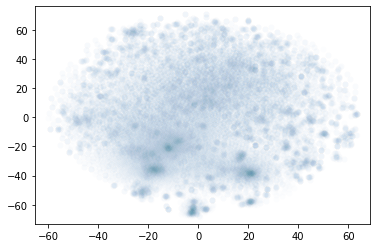

In [27]:
x,y = X2.T
plt.scatter(x, y, linewidths= 0.0, alpha=0.01)
plt.xlim( (x.min()-5, x.max()+5) )
plt.ylim( (y.min()-5, y.max()+5) )

In [ ]:
x[label_idx.cpu().numpy()],y[label_idx.cpu().numpy()]

In [ ]:
plt.hist( h_best[len(label_idx):].std(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Terms\n[VAR(h1), VAR(h2), ..., VAR(hn)]' )

In [ ]:
plt.hist( h_best[label_idx].mean(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Labels\n[AVG(h1), AVG(h2), ..., AVG(hn)]' )

In [ ]:
plt.hist( h_best[len(label_idx):].mean(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Terms\n[AVG(h1), AVG(h2), ..., AVG(hn)]' )

In [ ]:
label_idx = big_graph_dgl.ndata['label'].nonzero().flatten()

In [ ]:
h = gat(big_graph_dgl)
h.shape

In [ ]:
labels_hiddens = h[label_idx]
labels_hiddens

In [ ]:
A = []
B = []
y = []
for i in range(labels_hiddens.size()[0]):
    for j in range(labels_hiddens.size()[0]):
        if i != j:
            A.append( labels_hiddens[i] )
            B.append( -1.*labels_hiddens[j] )
            y.append( 1 )
            
B=torch.cat(B).reshape( len(y), 300 )
A=torch.cat(A).reshape( len(y), 300 )
y=torch.Tensor(y)

In [ ]:
loss_func(B, A, target=y), loss_func(A, B, target=y)

In [ ]:
gat.train()
torch.cuda.synchronize()

In [ ]:
class TGA(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_class,
                  n_heads=8, drop=.5, attn_drop=.5,
                  device='cuda:0'):
        super(TGA, self).__init__()
        self.n_class = n_class
        self.device = torch.device(device)
        self.gat_global = GenericGAT(in_dim, hidden_dim, 
                                     encoders={'label'}, 
                                     n_heads=n_heads, drop=drop,
                                     attn_drop=attn_drop, device=self.device)
        
        self.gat_local  = GenericGAT(hidden_dim, hidden_dim, 
                                     encoders={'term'}, 
                                     n_heads=n_heads, drop=drop,
                                     first_hidden='emb',
                                     attn_drop=attn_drop, device=self.device)

        self.lin = nn.Linear( hidden_dim, 1).to(self.device)
        # Depois tentar alguma ativação (ReLU, por exemplo, pode "desativar" alguns termos no softmax)
        self.pooling = GlobalAttentionPooling( self.lin ).to(self.device)

        # Fully Connected
        self.fc1 = nn.Linear( hidden_dim, hidden_dim//2).to(self.device)
        self.fc2 = nn.Linear( hidden_dim//2, hidden_dim//4).to(self.device)
        self.fc3 = nn.Linear( hidden_dim//4, self.n_class).to(self.device)
    def forward(self, G, gs):
        #h_global           = self.gat_global( G, label=G.ndata['label'].nonzero().flatten() )
        #gs.ndata['weight'] = h_global[ gs.ndata['idx'] ] # Tentar concatenando
        h_local            = self.gat_local(gs, term=None)
        #h_local            = torch.cat((h_local, h_global[ gs.ndata['idx'] ]), 1)
        h_local            = self.pooling( gs, h_local )
        h_local            = self.fc1( h_local )
        h_local            = self.fc2( h_local )
        h_local            = self.fc3( h_local )
        return h_local
# torch.Size([3652, 300]) torch.Size([3652, 300]) torch.Size([128, 300])
        

In [ ]:
in_dim=300
hidden_dim=2
n_heads=8
drop=0.3
attn_drop=0.5
batch_size=128
device='cuda:0'

In [ ]:
model = TGA( in_dim, hidden_dim, graph_builder.n_class,
            n_heads=n_heads, drop=drop, attn_drop=attn_drop )
model

In [ ]:
def collate(param):
    X, y = zip(*param)
    Gs_nx = graph_builder.transform(X)
    
    Gs_dgl_list = []
    idx_terms = { l for l in graph_builder.label_ids }
    for g in Gs_nx:
        g_dgl = dgl.DGLGraph()
        g_dgl.from_networkx(g, node_attrs=['emb', 'idx'] )
        Gs_dgl_list.append( g_dgl )
        
        idx_terms = idx_terms.union( set(nx.get_node_attributes(g,'idx').values()) )
    
    Gs_dgl = dgl.batch(Gs_dgl_list)
    
    big_graph_dgl = dgl.DGLGraph()
    big_graph_dgl.from_networkx(graph_builder.g, node_attrs=['emb', 'label', 'idx'] )
    
    #subgraph = graph_builder.g.subgraph(idx_terms)
    #big_graph_dgl.from_networkx(subgraph, node_attrs=['emb', 'label', 'idx'] )
    
    return big_graph_dgl, Gs_dgl, torch.tensor(y)

In [ ]:
loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam( model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = optim.AdamW( model.parameters(), lr=1e-2, weight_decay=1e-3)

#optimizer = optim.RMSprop( model.parameters(), lr=1e-2, weight_decay=1e-4)
#optimizer = optim.RMSprop( model.parameters(), lr=0.0001 )

model.train()
torch.cuda.synchronize()

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    epoch_loss = 0
    data_loader = DataLoader(list(zip(fold.X_train, fold.y_train)), batch_size=batch_size,
                             shuffle=True, collate_fn=collate, num_workers=2)
    with tqdm(total=len(fold.y_train)) as pbar:
        total = 1
        correct = 1
        model.train()
        for G, gs, y in data_loader:
            G = G.to( torch.device('cuda:0') )
            gs = gs.to( torch.device('cuda:0') )
            y = y.to( torch.device('cuda:0') )
            
            optimizer.zero_grad()
            
            outputs = model( G, gs )
            probs_Y = torch.softmax(outputs, 1)
            sampled_Y = torch.argmax(probs_Y, 1).reshape(-1)
            
            total += y.size(0)
            correct += (sampled_Y == y).sum().item()
            
            del probs_Y, sampled_Y, G, gs
            
            # NN backprop phase
            loss = loss_func(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()
            
            pbar.update( len(y) )
            pbar.set_description_str(f'iter {epoch} Acc train: {correct/total:.3}')

In [ ]:
g = nx.Graph()
g.add_nodes_from( [ (0, {'idx': 0}), (1, {'idx': 1}), (2, {'idx': 2}) ] )

In [ ]:
list(nx.get_node_attributes(g,'idx').values())

In [ ]:
outputs

In [ ]:
labels_hiddens = torch.eye( 11 )
labels_hiddens